# Simultaneous analysis

For [studying the voltage comparison](VoltageAnalysis.ipynb) we can use the other cameras data to correct out overall night trends.

First we want to see how similar the sky background levels are between cameras. They *should* be identical.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import fits
from collections import namedtuple
from scipy import interpolate as interp
import pandas as pd
import pymysql
import sqlalchemy as sa

sns.set(style='white', context='talk')

In [2]:
TimeSeries = namedtuple('TimeSeries', ['x', 'y'])

In [3]:
def get_sky_level(filename):
    imagelist = fits.getdata(filename, 'imagelist')
    return TimeSeries(imagelist['tmid'], imagelist['skylevel'])

We start with 223 voltage

In [173]:
colours = dict(zip([802, 805, 806, 801], sns.color_palette(n_colors=10)))

In [5]:
sky802 = get_sky_level('data/223.fits')
sky805 = get_sky_level('data/comparison-223-805.fits')
sky806 = get_sky_level('data/comparison-223-806.fits')

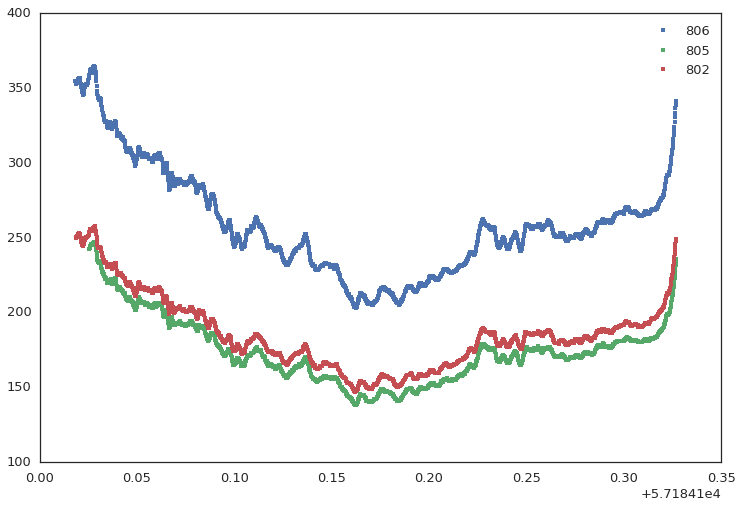

In [6]:
fig, axis = plt.subplots()
axis.plot(sky806.x, sky806.y, '.', label='806', color=colours[806])
axis.plot(sky805.x, sky805.y, '.', label='805', color=colours[805])
axis.plot(sky802.x, sky802.y, '.', label='802', color=colours[802])
axis.legend(loc='best')
fig.tight_layout()

These look similar, but with a different gain perhaps. Let's focus on 805 and 802, taking 802 as a reference.

To compute the ratio we have to interpolate one of them. 802 has the longest data set to use this as the interpolate source and use linear interpolation.

In [7]:
sky805_sub = TimeSeries(sky805.x[5:-5], sky805.y[5:-5])
sky806_sub = TimeSeries(sky806.x[5:-5], sky806.y[5:-5])

In [8]:
interpolator = interp.interp1d(sky802.x, sky802.y, kind='slinear')
sky_ratio_805 = sky805_sub.y / interpolator(sky805_sub.x)
sky_ratio_806 = sky806_sub.y / interpolator(sky806_sub.x)

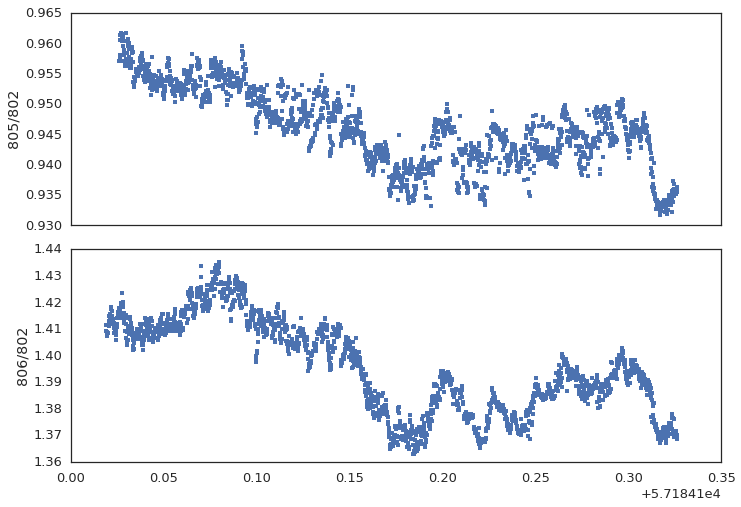

In [9]:
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(sky805_sub.x, sky_ratio_805, '.')
axes[1].plot(sky806_sub.x, sky_ratio_806, '.')

axes[0].set(ylabel='805/802')
axes[1].set(ylabel='806/802')
fig.tight_layout()

These values are not quite the same. Does this point to differences between the cameras? It does look like the 805/802 ratio is similar to the 806/802 ratio but with an extra signal on top. Perhaps 802 has some unusual behaviour? Just in case it's an issue with the pipeline, look into what Paladin measures as the sky background levels.

In [ ]:
engine = sa.create_engine('mysql+pymysql://sw@ngtsdb/ngts_ops')

In [10]:
df = pd.read_sql_query('''select camera_id, mjd, bkg_mean_ctsec, img_median_cts, gain_factor, bias_mean_adu from raw_image_list
    where night = "20150610" and field like "NG2000%%" and image_class = "SCIENCE"''', con=engine)

In [11]:
df.head()

,camera_id,mjd,bkg_mean_ctsec,img_median_cts,gain_factor,bias_mean_adu
0,802,57184.118565,72.4504,723.753,2.93,1300.43
1,802,57184.118715,72.4947,724.277,2.93,1300.33
2,802,57184.118866,72.5851,725.345,2.93,1300.21
3,802,57184.119005,72.6366,725.788,2.93,1300.29
4,802,57184.119155,72.6708,726.142,2.93,1300.15


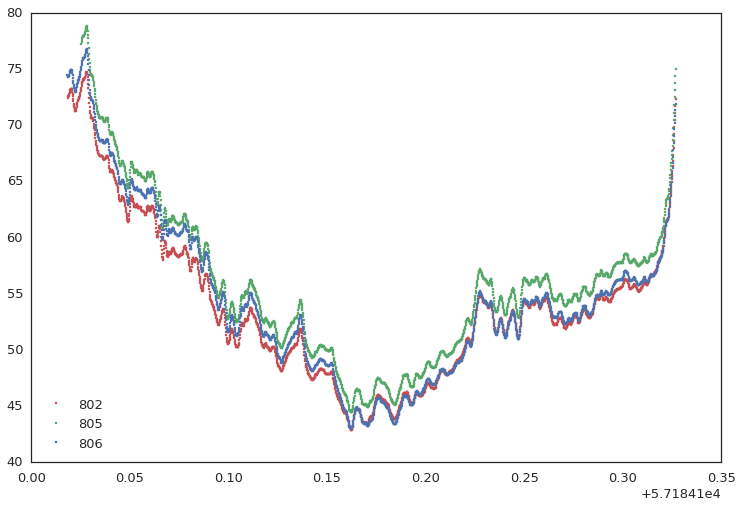

In [12]:
fig, axis = plt.subplots()
for i, camera_id in enumerate([802, 805, 806]):
    subset = df[df.camera_id == camera_id]
    axis.plot(subset.mjd, subset.bkg_mean_ctsec, '.', ms=5, label=camera_id, color=colours[camera_id])
axis.legend(loc='best')
fig.tight_layout()

The background level as computed by Paladin shows similar levels. The offset between the lines is perhaps expected as we do not have accurate gain values (I think these units are electrons?), and the structure is similar.

What's interesting is between 0.15 and 0.25 where the blue and red lines overlie each other. Perhaps there is something going on at this time?

What are the bias levels doing?

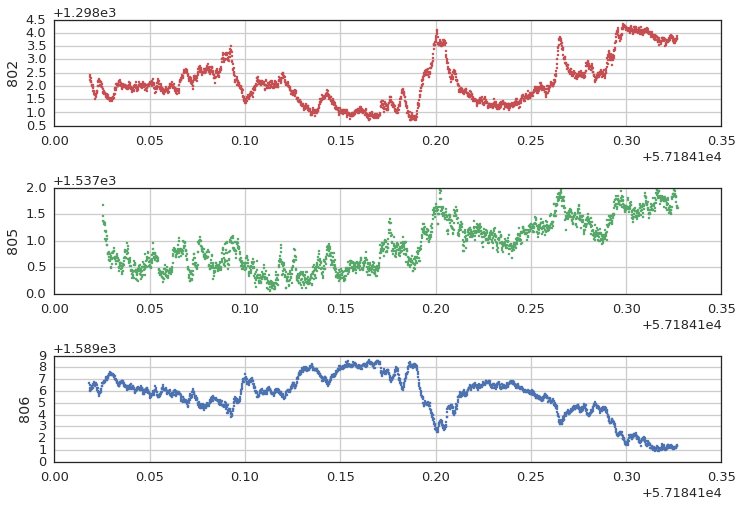

In [13]:
fig, axes = plt.subplots(3, 1)
for ax, camera_id in zip(axes, [802, 805, 806]):
    subset = df[df.camera_id == camera_id]
    ax.plot(subset.mjd, subset.bias_mean_adu, '.', ms=5, label=camera_id, color=colours[camera_id])
    ax.set(ylabel=camera_id)
    ax.grid(True)

fig.tight_layout()

In [162]:
mjd0 = int(df.mjd.min()) - 1

We do know that 802 is at a different voltage to the others. Perhaps we should analyse the night at which they all have the same voltages. Let's consider the night with the "default" voltages.

<table>
<tr><th>Night</th><th>Camera id</th><th>Voltage</th><th>Same voltage as?</th></tr>
<tr><td>20150609</td><td>802</td><td><b>122</b></td><td>806</td></tr>
<tr><td>20150609</td><td>805</td><td>223</td><td>-</td></tr>
<tr><td>20150609</td><td>806</td><td>122</td><td>802</td></tr>

<tr><td>20150610</td><td>802</td><td><b>223</b></td><td>-</td></tr>
<tr><td>20150610</td><td>805</td><td>122</td><td>806</td></tr>
<tr><td>20150610</td><td>806</td><td>122</td><td>805</td></tr>

<tr><td>20150611</td><td>802</td><td><b>168</b></td><td>-</td></tr>
<tr><td>20150611</td><td>805</td><td>122</td><td>806</td></tr>
<tr><td>20150611</td><td>806</td><td>122</td><td>805</td></tr>
</table>

The best comparison for 802 is therefore 20150609.

In [181]:
def compare(night, camera_ids, axis=None):
    df = pd.read_sql_query('''
        select camera_id, mjd, bkg_mean_ctsec, img_median_cts, gain_factor, bias_mean_adu, start_time_utc
        from raw_image_list
        where night = %s
        and field like "NG200%%"
        and image_class = "SCIENCE"
        and camera_id in %s
        ''', con=engine, params=(night, camera_ids), index_col='start_time_utc')
    axis.set_title(night)
    sub_dfs = []
    for camera_id in sorted(df.camera_id.unique()):
        sample = df[df.camera_id == camera_id]
        axis.plot(sample.mjd - mjd0, sample.bkg_mean_ctsec, '.', ms=3, color=colours[camera_id], label=camera_id)
        sub_dfs.append(sample)
    return sub_dfs

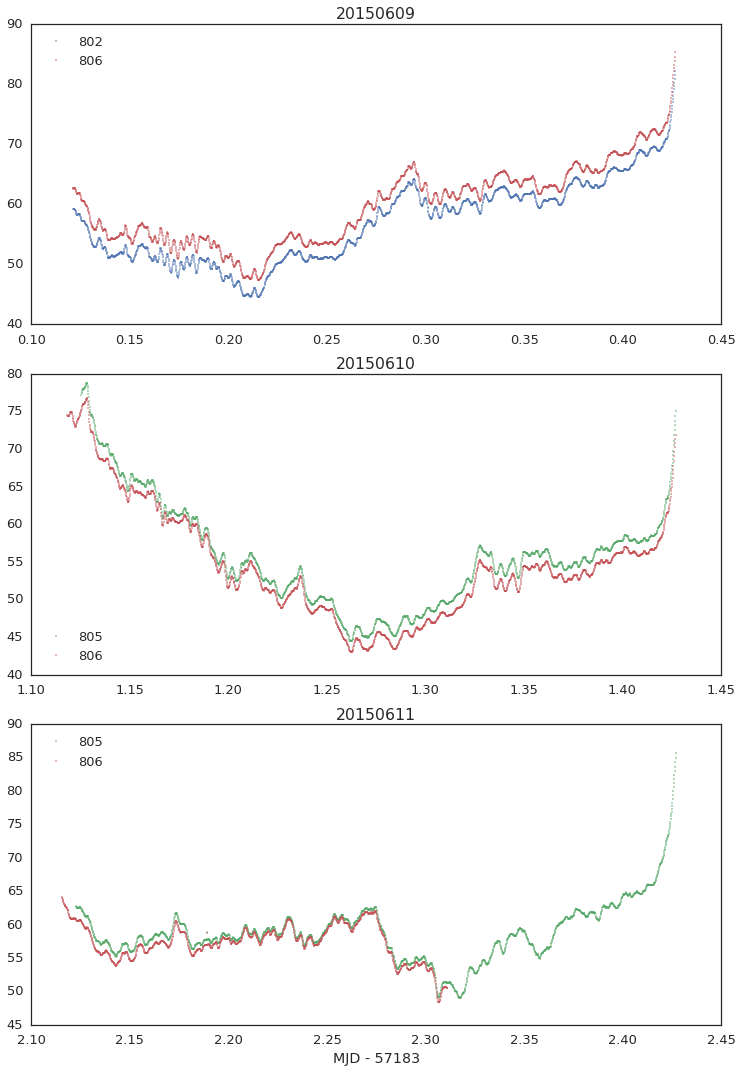

In [182]:
fig, axes = plt.subplots(3, 1, figsize=(10.4, 15))
df_20150609 = compare('20150609', (802, 806), axes[0])
df_20150610 = compare('20150610', (805, 806), axes[1])
df_20150611 = compare('20150611', (805, 806), axes[2])
for ax in axes:
    ax.legend(loc='best')
axes[-1].set_xlabel(r'MJD - {}'.format(mjd0))
fig.tight_layout()
fig.savefig('plots/sky_background_paladin.png')

All three of these time series show different behaviour. To get the differences, we have to resample the data onto the same grid. We choose one minute bins.

In [183]:
resample_time = 'T' # Minutely
merged_20150609 = pd.merge(df_20150609[0].resample(resample_time), df_20150609[1].resample(resample_time),
                           left_index=True, right_index=True)
merged_20150610 = pd.merge(df_20150610[0].resample(resample_time), df_20150610[1].resample(resample_time),
                           left_index=True, right_index=True)
merged_20150611 = pd.merge(df_20150611[0].resample(resample_time), df_20150611[1].resample(resample_time),
                           left_index=True, right_index=True)

In [184]:
def plot_merged(merged, axis):
    axis.plot(merged.mjd_x - mjd0, merged.bkg_mean_ctsec_y - merged.bkg_mean_ctsec_x, '.')
    axis.set_ylabel('{} - {}'.format(
            merged.camera_id_y.unique()[0],
            merged.camera_id_x.unique()[0]))

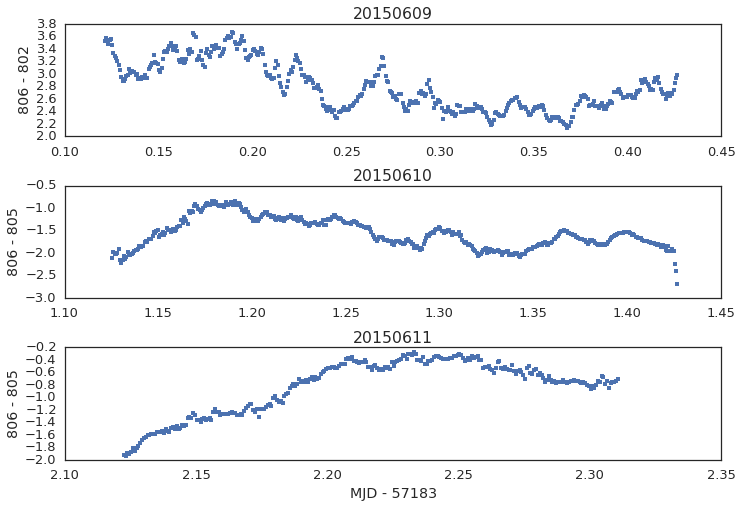

In [185]:
fig, axes = plt.subplots(3, 1)
for m, ax, title in zip([merged_20150609, merged_20150610, merged_20150611], axes,
                        ['20150609', '20150610', '20150611']):
    plot_merged(m, ax)
    ax.set_title(title)
axes[-1].set_xlabel('MJD - {}'.format(mjd0))
fig.tight_layout()
fig.savefig('plots/sky_background_paladin_differences.png')